In [16]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pulp

### Load data

In [17]:
selection_df = pd.read_pickle('../../data/processed/selection_candidates.pkl')

In [18]:
selection_df.columns

Index(['clean_name', 'lgb_predictions', 'pos', 'value', 'prev_season_total'], dtype='object')

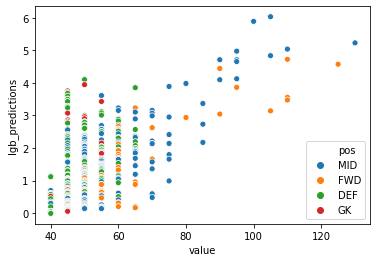

In [19]:
sns.scatterplot(data=selection_df,x='value',y='lgb_predictions',hue='pos')

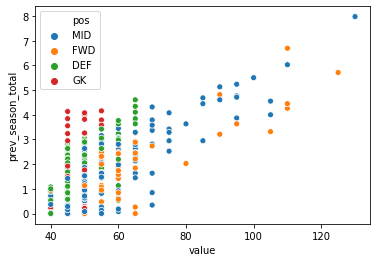

In [20]:
sns.scatterplot(data=selection_df,x='value',y='prev_season_total',hue='pos')

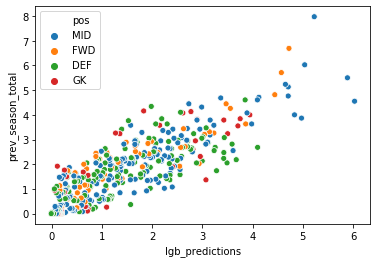

In [21]:
sns.scatterplot(data=selection_df,x='lgb_predictions',y='prev_season_total',hue='pos')

### Select best 15 players

choose highest expected points per game, subject to constraints on total cost, and positions 

note - doesn't capture fact that subs are less valuable (particularly 2nd keeper)

In [22]:
selection_df.columns

Index(['clean_name', 'lgb_predictions', 'pos', 'value', 'prev_season_total'], dtype='object')

removing new-joiners, and manually dropping some guys that moved club

In [23]:
selection_df = selection_df.loc[selection_df.prev_season_total.notna(),:].reset_index(drop=True)

In [24]:
selection_df = selection_df.loc[~selection_df.clean_name.isin(['Xherdan_Shaqiri','Riyad_Mahrez','Thibaut_Courtois']),:]

In [25]:
def select_best_15(data,prediction_col):
    player_ids = [str(i) for i in range(data.shape[0])]

    # Setup
    point = dict(zip(player_ids,data[prediction_col]))
    cost = dict(zip(player_ids,data.value))
    gk = dict(zip(player_ids,(data.pos == 'GK').astype(int)))
    defe = dict(zip(player_ids,(data.pos == 'DEF').astype(int)))
    mid = dict(zip(player_ids,(data.pos == 'MID').astype(int)))
    stri = dict(zip(player_ids,(data.pos == 'FWD').astype(int)))
    
    prob = pulp.LpProblem("Fantasy Football",pulp.LpMaximize)
    player_vars = pulp.LpVariable.dicts("Players",player_ids,0,1,pulp.LpBinary)

    # objective function
    prob += pulp.lpSum([point[i]*player_vars[i] for i in player_ids]), "Total Cost"

    # constraint
    prob += pulp.lpSum([player_vars[i] for i in player_ids]) == 15, "Total 15 Players"
    prob += pulp.lpSum([cost[i] * player_vars[i] for i in player_ids]) <= 1000, "Total Cost"
    prob += pulp.lpSum([gk[i] * player_vars[i] for i in player_ids]) == 2, "2 GK"
    prob += pulp.lpSum([defe[i] * player_vars[i] for i in player_ids]) == 5, "5 DEF"
    prob += pulp.lpSum([mid[i] * player_vars[i] for i in player_ids]) == 5, "5 MID"
    prob += pulp.lpSum([stri[i] * player_vars[i] for i in player_ids]) == 3, "Less than 3 STR"

    # solve
    status = prob.solve()
    
    return status, prob, [int(f.name.replace('Players_','')) for f in prob.variables() if f.varValue == 1 ]

In [26]:
_, _, selections_prev_total = select_best_15(selection_df,'prev_season_total')

In [27]:
_, _, selections_lgb = select_best_15(selection_df,'lgb_predictions')

In [28]:
def show_team(candidates, selection):
    position_map = {'GK':1,'DEF':2,'MID':3,'FWD':4}
    candidates['position_num'] = candidates.pos.map(position_map)
    return candidates.iloc[selection].sort_values(by='position_num').drop(columns='position_num')

In [29]:
selected_prev_total = show_team(selection_df,selections_prev_total); selected_prev_total

,clean_name,lgb_predictions,pos,value,prev_season_total
20,Mathew_Ryan,3.753063,GK,45,3.842105
63,Lukasz_Fabianski,2.772827,GK,45,4.131579
131,Marcos_Alonso,1.982674,DEF,65,4.342105
19,César_Azpilicueta,3.852352,DEF,65,4.605263
24,Mathias_Jorgensen,3.592165,DEF,45,2.815789
44,Héctor_Bellerín,3.075740,DEF,55,3.473684
79,Nicolás_Otamendi,2.566345,DEF,65,4.105263
2,Mohamed_Salah,5.228711,MID,130,7.973684
38,Abdoulaye_Doucouré,3.229332,MID,60,3.578947
51,Pascal_Groß,2.986606,MID,70,4.315789


In [30]:
selected_lgb = show_team(selection_df,selections_lgb); selected_lgb

,clean_name,lgb_predictions,pos,value,prev_season_total
20,Mathew_Ryan,3.753063,GK,45,3.842105
21,Jonas_Lössl,3.708302,GK,45,3.552632
13,Nathan_Aké,4.100739,DEF,50,2.684211
22,Steve_Cook,3.674800,DEF,45,2.184211
24,Mathias_Jorgensen,3.592165,DEF,45,2.815789
27,Wesley_Hoedt,3.491563,DEF,45,2.055556
30,Charlie_Daniels,3.428213,DEF,45,2.473684
0,Eden_Hazard,6.031679,MID,105,4.552632
1,Kevin_De Bruyne,5.889757,MID,100,5.500000
23,Ryan_Fraser,3.611738,MID,55,2.552632
